<a href="https://colab.research.google.com/github/MartinaWestrik/Eurosat-Neural-Networks/blob/EuroSAT_vlastni_model/Eurosat_Neural_Networks_V0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#INFO O PROJEKTU
**Cílem** projektu je vytrénování modelu, který na základě analýzy datasetu 27000 satelitních snímků ze zařízení Sentinel2 rozpoznává 10 druhů tříd land use - využití půdy, např. pole, pastvina, dálnice, jezera, řeky, zastavěné území, průmyslová zóna apod. Snímky mají po úpravě ze 13 spektrálního nastavení (EuroSATallBands, *tif) pouze tříbarvené kanály (RGB), rozměry 64x64 pixelů (EuroSAT, *.jpg) Projekt jsme si vybrali na https://www.kaggle.com/datasets/apollo2506/eurosat-dataset, k sestavování modelu jsme využili zdejší kody, chatgpt, vzorový příklad na Colab - šachy.

**Postup**

Postavení vlastního modelu neuronové sítě a ladění parametrů (V0)

Použití předtrénovaného modelu VGG16 (V1) a XXX (V2) pro efektivnější trénování.

Vyhodnocení modelů pomocí přesnosti a konfuzní matice.


# NAČÍTÁNÍ KNIHOVEN

In [57]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

import random
import numpy as np                                                   #knihovna pro práci s maticovými daty
import pandas as pd                                                  #knihovna pro práci s tabulkovými daty
import os

import matplotlib.pyplot as plt                                      #knihovna na vizualizaci                                                            #knihovna pro práci s adresáři
from PIL import Image                                                #modul PythonImagineLibrary je součástí knihovny Pillow otevírání, úpravy a ukládání obrázků v různých formátech (JPEG, PNG, BMP, GIF atd.).
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator  #nástroj pro augmentaci - dávkuje načítání, generuje nové obrázky, normalizuje obrázky)
from tensorflow.keras.callbacks import EarlyStopping                 #mechanismus bránící přeučení tím, že se zastaví, když se přestane model zlepšovat ve vybraných parametrech
from tensorflow.keras.callbacks import ModelCheckpoint               #ukládá nejlepší verzi modelu, nejlepší váhy, při přerušení lze načíst poslední verzi a pokračovat z posledního checkpointu
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import confusion_matrix, classification_report

# NAČTENÍ DAT


In [58]:
# Stažení aktuální verze dat z Kaggle
path_to_download = kagglehub.dataset_download("apollo2506/eurosat-dataset")
print("Obsah datasetu:")
print(os.listdir(path_to_download))

Obsah datasetu:
['EuroSATallBands', 'EuroSAT']


In [59]:
# Vyhledání všech CSV souborů
csv_files = []
for root, dirs, files in os.walk(path_to_download):
    for file in files:
        if file.endswith(".csv"):
            csv_files.append(os.path.join(root, file))

# Výpis nalezených CSV souborů
print("Nalezené CSV soubory:\n")
for csv in csv_files:
    print(csv)

Nalezené CSV soubory:

/root/.cache/kagglehub/datasets/apollo2506/eurosat-dataset/versions/6/EuroSATallBands/train.csv
/root/.cache/kagglehub/datasets/apollo2506/eurosat-dataset/versions/6/EuroSATallBands/validation.csv
/root/.cache/kagglehub/datasets/apollo2506/eurosat-dataset/versions/6/EuroSATallBands/test.csv
/root/.cache/kagglehub/datasets/apollo2506/eurosat-dataset/versions/6/EuroSAT/train.csv
/root/.cache/kagglehub/datasets/apollo2506/eurosat-dataset/versions/6/EuroSAT/validation.csv
/root/.cache/kagglehub/datasets/apollo2506/eurosat-dataset/versions/6/EuroSAT/test.csv


In [60]:
# Načtení CSV souborů = landuse labelů -  do tabulek
train_df = pd.read_csv(os.path.join(path_to_download, "EuroSAT/train.csv"))
val_df = pd.read_csv(os.path.join(path_to_download, "EuroSAT/validation.csv"))
test_df = pd.read_csv(os.path.join(path_to_download, "EuroSAT/test.csv"))

In [61]:
# Přidání úplné cesty k obrázkům
train_df["Filename"] = train_df["Filename"].apply(lambda x: os.path.join(path_to_download,"EuroSAT", x))
val_df["Filename"] = val_df["Filename"].apply(lambda x: os.path.join(path_to_download,"EuroSAT", x))
test_df["Filename"] = test_df["Filename"].apply(lambda x: os.path.join(path_to_download,"EuroSAT", x))


              Kategorie  Celkový počet snímků
0            AnnualCrop                  3000
1  HerbaceousVegetation                  3000
2               SeaLake                  3000
3                Forest                  3000
4           Residential                  3000
5         PermanentCrop                  2500
6            Industrial                  2500
7               Highway                  2500
8                 River                  2500
9               Pasture                  2000


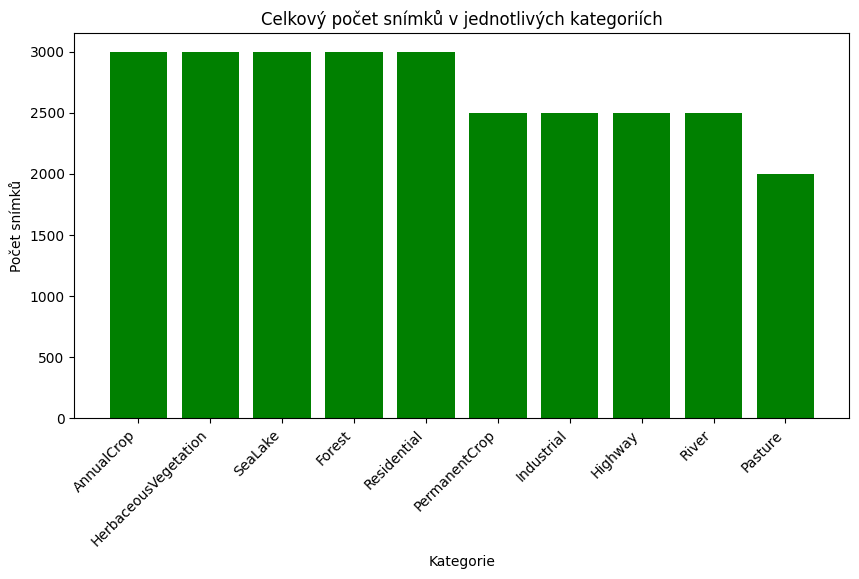

In [62]:
#Součet všech snímků v rámci kategorií:
# Spojení všech částí datasetu
full_df = pd.concat([train_df, val_df, test_df])

# Spočítání snímků podle kategorií
df_counts = full_df["ClassName"].value_counts().reset_index()
df_counts.columns = ["Kategorie", "Celkový počet snímků"]

# Výpis tabulky
print(df_counts)

# Vykreslení histogramu
plt.figure(figsize=(10, 5))
plt.bar(df_counts["Kategorie"], df_counts["Celkový počet snímků"], color="green")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Kategorie")
plt.ylabel("Počet snímků")
plt.title("Celkový počet snímků v jednotlivých kategoriích")
plt.show()

In [63]:
# Zobrazení prvních 5 řádků jako tabulky
print("Trénovací sada:")
display(train_df.head())  # Funguje jen v Jupyter Notebooku

print("\n Validační sada:")
display(val_df.head())

print("\n Testovací sada:")
display(test_df.head())

Trénovací sada:


,Unnamed: 0,Filename,Label,ClassName
0,16257,/root/.cache/kagglehub/datasets/apollo2506/eur...,0,AnnualCrop
1,3297,/root/.cache/kagglehub/datasets/apollo2506/eur...,2,HerbaceousVegetation
2,17881,/root/.cache/kagglehub/datasets/apollo2506/eur...,6,PermanentCrop
3,2223,/root/.cache/kagglehub/datasets/apollo2506/eur...,4,Industrial
4,4887,/root/.cache/kagglehub/datasets/apollo2506/eur...,2,HerbaceousVegetation



 Validační sada:


,Unnamed: 0,Filename,Label,ClassName
0,258,/root/.cache/kagglehub/datasets/apollo2506/eur...,5,Pasture
1,2134,/root/.cache/kagglehub/datasets/apollo2506/eur...,1,Forest
2,3518,/root/.cache/kagglehub/datasets/apollo2506/eur...,3,Highway
3,3048,/root/.cache/kagglehub/datasets/apollo2506/eur...,8,River
4,3996,/root/.cache/kagglehub/datasets/apollo2506/eur...,9,SeaLake



 Testovací sada:


,Unnamed: 0,Filename,Label,ClassName
0,2438,/root/.cache/kagglehub/datasets/apollo2506/eur...,0,AnnualCrop
1,1018,/root/.cache/kagglehub/datasets/apollo2506/eur...,7,Residential
2,3,/root/.cache/kagglehub/datasets/apollo2506/eur...,5,Pasture
3,1011,/root/.cache/kagglehub/datasets/apollo2506/eur...,7,Residential
4,47,/root/.cache/kagglehub/datasets/apollo2506/eur...,5,Pasture


In [64]:
# Vytvoření slovníku pro převod Label -> ClassName
label_to_class = train_df[["Label", "ClassName"]].drop_duplicates().set_index("Label")["ClassName"].to_dict()

# Výpis přiřazení
print("Přiřazení kategorií landuse:\n")
for label, class_name in sorted(label_to_class.items()):
    print(f"{label}: {class_name}")

Přiřazení kategorií landuse:

0: AnnualCrop
1: Forest
2: HerbaceousVegetation
3: Highway
4: Industrial
5: Pasture
6: PermanentCrop
7: Residential
8: River
9: SeaLake


# DATA - ANALÝZA A PREPROCESING

#Zjišťujeme,

1.   jaké mají fotky rozměry,
2.   vizuálně hodnotíme, jak fotky vypadají pro člověka a jak jsou barevně ne/pestré
3.   normalizace pixelových hodnot (škálování do rozmezí 0–1) a augmentace
4.   změna rozměrů obrázků - není třeba, když si stavíme model
5.   one-hot encoding labelů (převod kategorií na numerické vektory)
6.   kontrola dat v trénovací, validační a testovací sadě


### Ověření rozměrů fotek

In [65]:
sample_img_path = None
for root, _, files in os.walk(path_to_download):
    for file in files:
        if file.endswith((".jpg", ".png")):  # Zkontrolujeme, zda je to obrázek
            sample_img_path = os.path.join(root, file)
            break
    if sample_img_path:
        break

# Načtení a zjištění rozměrů
if sample_img_path:
    img = Image.open(sample_img_path)
    print(f"Náhodný RGB obrázek: {sample_img_path}")
    print(f"Rozlišení: {img.size}")  # (šířka, výška)
    print(f"Počet kanálů: {len(img.getbands())}")  # Očekáváme 3 (RGB)
else:
    print("❌ Nenašel jsem žádné RGB obrázky v datasetu!")

Náhodný RGB obrázek: /root/.cache/kagglehub/datasets/apollo2506/eurosat-dataset/versions/6/EuroSAT/Forest/Forest_2326.jpg
Rozlišení: (64, 64)
Počet kanálů: 3


### Vizuální zhodnocení kvality fotek = stačí rozlišení na tréning?

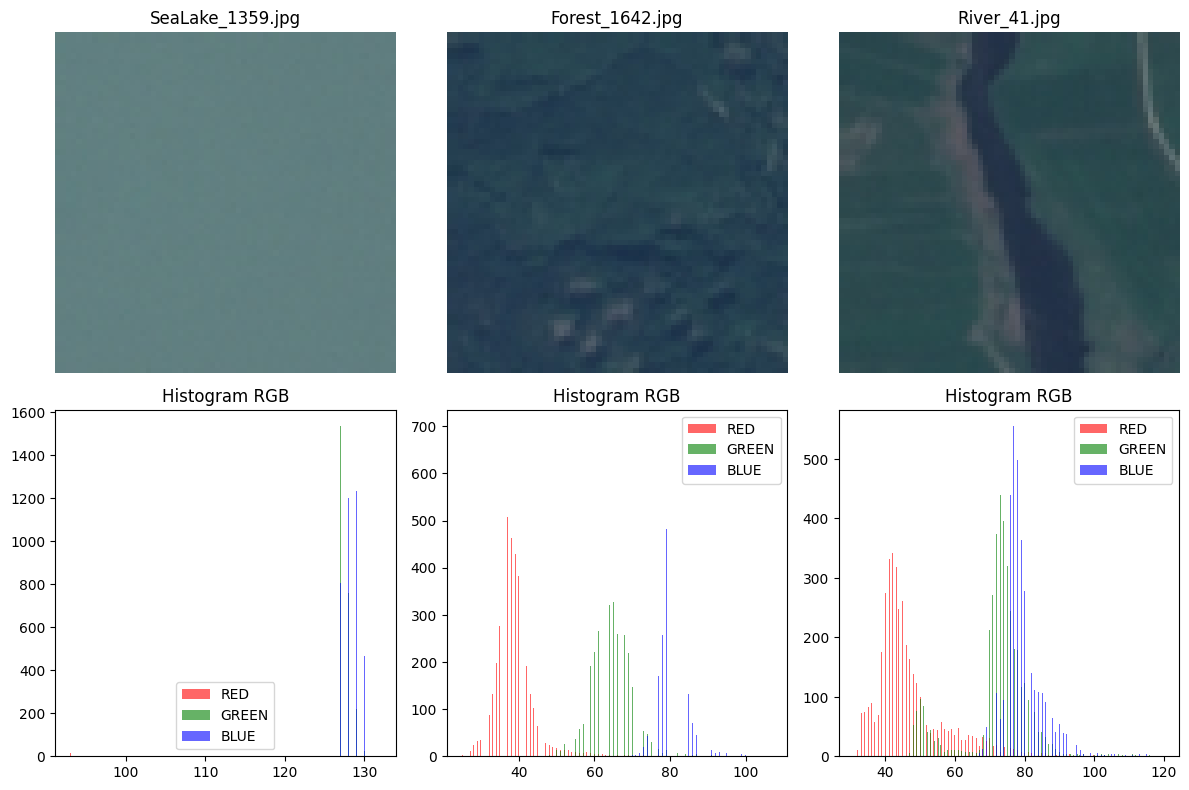

In [66]:
# Výběr 3 náhodných obrázků
all_images = []
for root, _, files in os.walk(path_to_download):
    all_images.extend([os.path.join(root, file) for file in files if file.endswith((".jpg", ".png"))])
random_images = random.sample(all_images, 3)

# Vykreslení obrázků a jejich histogramů
fig, axes = plt.subplots(2, 3, figsize=(12, 8))  # 2 řádky, 3 sloupce (obrázky nahoře, histogramy dole)

for i, img_path in enumerate(random_images):
    img = Image.open(img_path)
    img_array = np.array(img)  # Převod na NumPy pole

    # Vykreslení obrázku (horní řádek)
    axes[0, i].imshow(img)
    axes[0, i].set_title(os.path.basename(img_path))
    axes[0, i].axis("off")

    # Vykreslení histogramu RGB (dolní řádek)
    colors = ["red", "green", "blue"]
    for j, color in enumerate(colors):
        axes[1, i].hist(img_array[:, :, j].ravel(), bins=256, color=color, alpha=0.6, label=color.upper())

    axes[1, i].set_title("Histogram RGB")
    axes[1, i].legend()

plt.tight_layout()
plt.show()


###Normalizace sad a augmentace trénovací sady


In [67]:
# Trénovací data znormalizujeme a aplikujeme na ni augmentaci:
train_datagen = ImageDataGenerator(
    rescale=1./255,                 # normalizace pixelů (0–1)
    rotation_range=30,              # náhodná rotace
    width_shift_range=0.2,          # horizontální posun
    height_shift_range=0.2,         # nertikální posun
    zoom_range=0.2,                 # náhodné přiblížení
    horizontal_flip=False,          # zrcadlení jsem zakázala, protože stíny, směr sever apod...
    fill_mode="nearest"             # vyplní případně prázdné pixely barvou nejbližších okolních
)

val_datagen = ImageDataGenerator(
    rescale=1./255
    ) # Pouze normalizace, bez augmentace

### Převedení na stupně šedi a pak terpve normalizace - ZATÍM NEAPLIKOVÁNO



###Rozložení landuse kategorií v sadě trénovací/validační/testovací


In [68]:
def count_labels(df, dataset_name):
    label_counts = df["ClassName"].value_counts()  # Spočítání obrázků pro každou třídu
    print(f" Počet obrázků ve {dataset_name} sadě:\n")
    for label, count in label_counts.items():
        print(f"{label}: {count} obrázků")
    print("-" * 40)

# Spočítání pro všechny datasetové sady
count_labels(train_df, "trénovací")
count_labels(val_df, "validační")
count_labels(test_df, "testovací")

 Počet obrázků ve trénovací sadě:

AnnualCrop: 2100 obrázků
HerbaceousVegetation: 2100 obrázků
SeaLake: 2100 obrázků
Forest: 2100 obrázků
Residential: 2100 obrázků
PermanentCrop: 1750 obrázků
Industrial: 1750 obrázků
Highway: 1750 obrázků
River: 1750 obrázků
Pasture: 1400 obrázků
----------------------------------------
 Počet obrázků ve validační sadě:

Forest: 600 obrázků
AnnualCrop: 600 obrázků
HerbaceousVegetation: 600 obrázků
SeaLake: 600 obrázků
Residential: 600 obrázků
Highway: 500 obrázků
PermanentCrop: 500 obrázků
River: 500 obrázků
Industrial: 500 obrázků
Pasture: 400 obrázků
----------------------------------------
 Počet obrázků ve testovací sadě:

AnnualCrop: 300 obrázků
Residential: 300 obrázků
HerbaceousVegetation: 300 obrázků
SeaLake: 300 obrázků
Forest: 300 obrázků
PermanentCrop: 250 obrázků
Highway: 250 obrázků
River: 250 obrázků
Industrial: 250 obrázků
Pasture: 200 obrázků
----------------------------------------


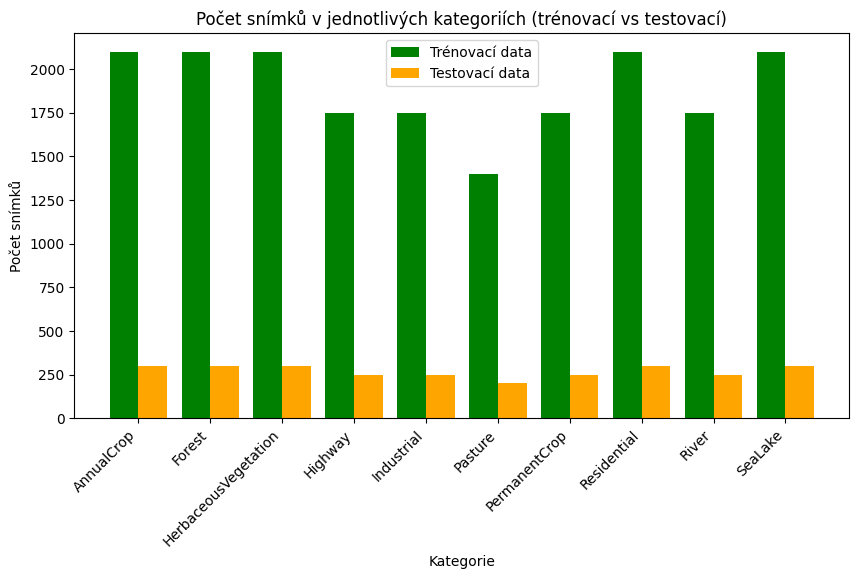

In [69]:
# Počet snímků v trénovací sadě
train_label_counts = train_df["Label"].value_counts().sort_index()

# Počet snímků v testovací sadě
test_label_counts = test_df["Label"].value_counts().sort_index()

# Vytvoření DataFrame
df_counts = pd.DataFrame({
    "Label": train_label_counts.index,
    "ClassName": [label_to_class[label] for label in train_label_counts.index],  # Převod labelů na názvy tříd
    "Počet snímků (trénovací)": train_label_counts.values,
    "Počet snímků (testovací)": test_label_counts.reindex(train_label_counts.index, fill_value=0).values
})

# Vykreslení sloupcového grafu s dvěma sadami dat
plt.figure(figsize=(10, 5))
bar_width = 0.4  # Šířka sloupců

# Pozice na ose x
x = range(len(df_counts["ClassName"]))

# Sloupce pro trénovací sadu (zelená)
plt.bar(x, df_counts["Počet snímků (trénovací)"], width=bar_width, color="green", label="Trénovací data")

# Sloupce pro testovací sadu (oranžová), posunuté doprava pro lepší viditelnost
plt.bar([i + bar_width for i in x], df_counts["Počet snímků (testovací)"], width=bar_width, color="orange", label="Testovací data")

# Popisky a legenda
plt.xticks([i + bar_width / 2 for i in x], df_counts["ClassName"], rotation=45, ha="right")  # Středování popisků mezi sloupci
plt.xlabel("Kategorie")
plt.ylabel("Počet snímků")
plt.title("Počet snímků v jednotlivých kategoriích (trénovací vs testovací)")
plt.legend()  # Přidání legendy
plt.show()

In [70]:

# Generátory dat
train_generator = train_datagen.flow_from_dataframe(
    train_df, x_col="Filename", y_col="ClassName", target_size=(64,64), batch_size=32, class_mode="categorical"
)
val_generator = val_datagen.flow_from_dataframe(
    val_df, x_col="Filename", y_col="ClassName", target_size=(64,64), batch_size=32, class_mode="categorical"
)

Found 18900 validated image filenames belonging to 10 classes.
Found 5400 validated image filenames belonging to 10 classes.


# DEFINICE MODELU

Je třeba napojit znormalizovaná data na model tak, aby se neukládala, ale upravovala se při vstupu do modelu.

##### **Připojení dat k generatoru (příklad se složkami datasetu)**
train_generator = datagen.flow_from_directory(
    "cesta_k_trenovacimu_datasetu",
    target_size=(64, 64),
    batch_size=32,
    class_mode="categorical"  # Používáme, pokud máme více tříd
)

Sequential - callback = early stopping, ukládání nejlepšího modelu kvůli kapacitě colabu => psát si výsledky + checkpoints

##Přednastavení


###Early Stopping


In [71]:
#nastavuji při vědomí, že se může val_accuracy ještě zlepšovat - rozpoznávání tříd
early_stopping = EarlyStopping(
    monitor="val_loss",      # sledujeme validační ztrátu
    patience=5,              # Po kolika epochách bez zlepšení zastavit trénování
    min_delta=0.05,
    restore_best_weights=True # Po zastavení vrátí nejlepší váhy modelu
)

###Model Checkpoint


In [72]:
#ukládání nejlepšího modelu;
model_checkpoint = ModelCheckpoint(
    "best_model.h5",       # název souboru pro uložení modelu
    monitor="val_loss",    # sledujeme validační ztrátu (nižší = lepší model)
    save_best_only=True,   # uloží pouze nejlepší model
    mode="min",            # protože chceme minimalizovat `val_loss`
    verbose=1              # výpis informací při ukládání
)

###ReduceLROnPlateau

In [73]:
#dynamické snižovnání rychlosti učení, brání zaseknutí v lokálním minimu, snižuje validační ztrátu = čím nižší, tím lepší model
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",   # sleduje val_loss
    factor=0.5,           # sníží learning rate na polovinu
    patience=3,           # ..po 3 epochách bez zlepšení
    min_lr=1e-6,          # minimální možná hodnota learning rate
    verbose=1             # výpíše informace při změně
)

## Postavení modelu


In [74]:
# vytvoření  vlastního modelu, ; Sequentional= každá vrstva přidává novou transformaci dat, která zlepšuje schopnost modelu rozpoznávat vzory
model = Sequential([
    # první konvoluční vrstva
    Input(shape=(64, 64, 3)),                                          #stabilizuje výstupy z neuronů
    Conv2D(32, (3,3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),                                          #32 filtrů hledá jiné vzory v matrici 3x3 pixely, "relu"převádí záporné hodnoty aktivační funkce na nulu, model očekává obrázky RGB 64x64
    MaxPooling2D(2,2),                                             # pooling snižuje velikost obrázků (na polovinu = 32x32) => snižuje rozsah výpočtu a vybírá ty nejdůležitější tvary na obrázku

    # druhá konvoluční vrstva
    Conv2D(64, (3,3), activation='relu', kernel_regularizer=l2(0.001)), #64 filtrů analyzuje složitější tvary, rysy na obrázku; kernel - velikost jádra
    BatchNormalization(),                                            #stabilizuje výstupy z neuronů
    MaxPooling2D(2,2),                                              # snižuje velikost obrázku na 16x16

    # třetí konvoluční vrstva
    Conv2D(128, (3,3), activation='relu', kernel_regularizer=l2(0.001)), #nasazuje 128 filtrů
    BatchNormalization(),                                             #stabilizuje výstupy z neuronů
    MaxPooling2D(2,2),                                               #snižuje velikost obrázku na 8x8

    # zploštění převede data z 8x8x128 => máme vektor s 8 192 prvky, které mohou vstoupit do dense vsrtvy se 128 neurony  a
    Flatten(),

    # .... do dense vsrtvy se 128 neurony a přirpavit se na klasifikaci
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),                                                   # v dense vrstvě "vypne" 50% neuronů, brání tím přeučení

    # výstupní vrstva s 10 třídami (softmax pro klasifikaci)
    Dense(10, activation='softmax')
])

###Optimizační algoritmus a ztrátová funkce

In [75]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),              #  optimalizuje váhy a optimalizační algoritmus; modelu říkám, že se má učit podle gradientu
    loss="categorical_crossentropy",  # vyhodnocení chyby a snaha o její znižování
    metrics=["accuracy"]              # nastavuje přesnost, abychom viděli výkon modelu
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 62, 62, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 29, 29, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 685,386 (2.61 MB)

 Trainable params: 684,938 (2.61 MB)

 Non-trainable params: 448 (1.75 KB)

###Batch size

In [76]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    batch_size=32,  # Nastavení batch size
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.4688 - loss: 2.2388
Epoch 1: val_loss improved from inf to 1.69457, saving model to best_model.h5


591/591 ━━━━━━━━━━━━━━━━━━━━ 219s 362ms/step - accuracy: 0.4690 - loss: 2.2381 - val_accuracy: 0.5244 - val_loss: 1.6946 - learning_rate: 0.0010
Epoch 2/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.6234 - loss: 1.4315
Epoch 2: val_loss did not improve from 1.69457
591/591 ━━━━━━━━━━━━━━━━━━━━ 208s 353ms/step - accuracy: 0.6234 - loss: 1.4314 - val_accuracy: 0.3891 - val_loss: 4.2171 - learning_rate: 0.0010
Epoch 3/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.6720 - loss: 1.2400
Epoch 3: val_loss improved from 1.69457 to 1.61348, saving model to best_model.h5


591/591 ━━━━━━━━━━━━━━━━━━━━ 197s 334ms/step - accuracy: 0.6721 - loss: 1.2400 - val_accuracy: 0.6050 - val_loss: 1.6135 - learning_rate: 0.0010
Epoch 4/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.6981 - loss: 1.1238
Epoch 4: val_loss did not improve from 1.61348
591/591 ━━━━━━━━━━━━━━━━━━━━ 197s 334ms/step - accuracy: 0.6981 - loss: 1.1238 - val_accuracy: 0.6072 - val_loss: 1.6946 - learning_rate: 0.0010
Epoch 5/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.7162 - loss: 1.0657
Epoch 5: val_loss did not improve from 1.61348
591/591 ━━━━━━━━━━━━━━━━━━━━ 198s 335ms/step - accuracy: 0.7162 - loss: 1.0657 - val_accuracy: 0.5478 - val_loss: 1.9649 - learning_rate: 0.0010
Epoch 6/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.7425 - loss: 0.9957
Epoch 6: val_loss improved from 1.61348 to 1.08869, saving model to best_model.h5


591/591 ━━━━━━━━━━━━━━━━━━━━ 198s 334ms/step - accuracy: 0.7425 - loss: 0.9956 - val_accuracy: 0.7407 - val_loss: 1.0887 - learning_rate: 0.0010
Epoch 7/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.7712 - loss: 0.9301
Epoch 7: val_loss did not improve from 1.08869
591/591 ━━━━━━━━━━━━━━━━━━━━ 194s 328ms/step - accuracy: 0.7712 - loss: 0.9302 - val_accuracy: 0.6535 - val_loss: 1.4540 - learning_rate: 0.0010
Epoch 8/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.7693 - loss: 0.9487
Epoch 8: val_loss improved from 1.08869 to 0.82995, saving model to best_model.h5


591/591 ━━━━━━━━━━━━━━━━━━━━ 208s 352ms/step - accuracy: 0.7693 - loss: 0.9487 - val_accuracy: 0.8228 - val_loss: 0.8299 - learning_rate: 0.0010
Epoch 9/50
552/591 ━━━━━━━━━━━━━━━━━━━━ 12s 319ms/step - accuracy: 0.7959 - loss: 0.9042

KeyboardInterrupt: 

# TRÉNOVÁNÍ MODELU


##První a druhé spuštění modelu

-  **ukončeno zásahem uživatelem po 10 minutách** kvůli stagnaci accuray kolem hodnoty 0,83, ztrátové funkce 0,5, validační přesnosti 0,87, validační ztrátě 0,359 a learning rate 0,001.
- **ukončeno po 13i epochách po 7,5 minutě** na aacuracy 0,9, loss 0,3, val_accuracy 0,91, val_loss 0,28 a leasning rate 0,00005
- ** třetí běh modelu** vylepšení:
🔹 ✅ Použití BatchNormalization() → Normalizace aktivací mezi vrstvami urychlí trénování a stabilizuje model.
🔹 ✅ Jemnější dropout → Snížení dropout na 0.4 místo 0.5 může pomoci, aby model neztrácel příliš mnoho informací.
🔹 ✅ Změna velikosti jader (kernel_size) → Může zlepšit extrakci rysů.
 🔹 ✅ Snížení Learning rate na 0,0001




# Vyhodnocení modelu



In [77]:
#Vykreslení rozvoje přesnosti a ztráty
def plot_training_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Graf ztráty (Loss)
    axs[0].plot(history.history['loss'], label='Trénovací ztráta')
    axs[0].plot(history.history['val_loss'], label='Validační ztráta')
    axs[0].set_title('Vývoj ztráty (Loss)')
    axs[0].set_xlabel('Epochy')
    axs[0].set_ylabel('Ztráta')
    axs[0].legend()

    # Graf přesnosti (Accuracy)
    axs[1].plot(history.history['accuracy'], label='Trénovací přesnost')
    axs[1].plot(history.history['val_accuracy'], label='Validační přesnost')
    axs[1].set_title('Vývoj přesnosti (Accuracy)')
    axs[1].set_xlabel('Epochy')
    axs[1].set_ylabel('Přesnost')
    axs[1].legend()

    plt.show()
    return history


In [78]:
# 15. Vyhodnocení modelu na validační sadě
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validační přesnost: {val_acc:.4f}")

169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - accuracy: 0.7173 - loss: 1.1753
Validační přesnost: 0.7100


In [86]:
test_datagen = ImageDataGenerator(rescale=1./255)  # pouze normalizace, žádná augmentace

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col="Filename",
    y_col="ClassName",
    target_size=(64,64),
    batch_size=32,
    class_mode="categorical"
)

# Predikce modelu
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)  # Převedeme pravděpodobnosti na predikované tříd
y_true = test_df["Label"].values  # ✅ Skutečné hodnoty z CSV


Found 2700 validated image filenames belonging to 10 classes.
 1/85 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step


# Analýza chyb



In [91]:
# Konfuzní matice
conf_matrix = confusion_matrix(y_true, y_pred)

# Vykreslení konfuzní matice
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=lablels, yticklabels=labels)
plt.xlabel("Predikované třídy")
plt.ylabel("Skutečné třídy")
plt.title("Konfuzní matice")
plt.show()


NameError: name 'lablels' is not defined

<Figure size 1000x700 with 0 Axes>

# Shrnutí výsledků


In [ ]:
# Klasifikační report
report = classification_report(y_true, y_pred, target_names=class_labels)
print("📊 Klasifikační report:\n", report)

# Závěr
Shrnutí celého procesu: od přípravy datasetu po analýzu výsledků.
Možnosti aplikace modelu v praxi (např. monitoring změn krajiny, urbanizace).
Doporučení pro budoucí vylepšení modelu.